# Modal analysis of a 2D-beam

In this notebook we have a free vibrating beam without any force applied to look at the free vibrating modes and how to deal with rigid body motions.

We will import dolfin, mshr and the python packages <code>numpy</code>, <code>matplotlib</code> (and <code>pyplot</code>) and <code>petsc4py</code>.

In [34]:
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import petsc4py
%matplotlib inline

The example is a domain with length of 1 meter and a width of 2.5 centimeters. We take material properties of steel and do not take damping into account.

The force applied is a lineaic pressure of 5 kPa per meter at the end of the beam. 

Gravity is taken into account but it can be neglected under the current material properties and applied load. However, for future applications of modal analysis it is easy to have a body force included as well.

In [35]:
# Domain parameters
ll = 1.0
ww = 0.025

# Mesh density
dens = 100

# Elasticity parameters
E, nu = 2.1e9, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Mass density and viscous damping coefficient
rho, eta = 7.8e4, 0.0

# applied force
pressure = -5e4
grav = -9.81

Creating a mesh and its boundaries:

In [36]:
# Create mesh
P0 = Point(0., 0.)
P1 = Point(ll, ww)
domain = mshr.Rectangle(P0, P1)
mesh = mshr.generate_mesh(domain, dens)

# Mark boundary subdomians
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 0.))
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], ll))
    
class BoundaryTop(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(ww, x[1]))
    
class BoundaryBottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(0, x[1]))

# set boundary markers
boundary_markers = FacetFunction('size_t', mesh)
left = BoundaryLeft()
right = BoundaryRight()
top = BoundaryTop()
bottom = BoundaryBottom()
left.mark(boundary_markers, 0)
top.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)
bottom.mark(boundary_markers, 3)

# Define measure ds to apply markers
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

Defining loads and taking inertia into account for the governing balance equation

There are a number of functions defined on the vectorspace $\mathcal{V}$: the displacement, velocity and acceleration. 

The beam is clamped on the left, therefore Dirichlet boundary conditions are applied to set the displacement to zero there.

The material is modeled as homogenous and isotropic so the stress tensor is given simply by:
$$
\boldsymbol{\sigma} = \mu\boldsymbol{\epsilon} + \lambda \text{tr}(\boldsymbol{\epsilon})\mathbf{I}
$$

In [37]:
# Create function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Create test and trial functions, and source term
u1, w = TrialFunction(V), TestFunction(V)
v1 = TestFunction(V)

# Fields from previous step
u0, v0, a0 = Function(V), Function(V), Function(V)

# Define loads
#bb = Constant((0., grav))
#tt = Constant((0.0, pressure))

# Define boundary conditions
#bc = DirichletBC(V, Constant((0.0, 0.0)), left)

# Stress function
def sigma(u, v):
    return 2.0*mu*sym(grad(u)) + (lmbda*tr(grad(u)) + eta*tr(grad(v)))*Identity(len(u))

Using PETSc-matrices we can set up the stiffness, mass and force vectors of the domain by using the stiffness of the beam given by inner product of the stress and deformation: $<\sigma, \epsilon>$. The mass is calculated using the density and the force is defined by the body force (gravity) and a load applied on the beam edge to the right, which is given.

In [38]:
# Dummy  boundary condition
class DummyBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(-1, -1))

dummyboundary = DummyBoundary()
dummy_bc = DirichletBC(V, Constant((0.0, 0.0)), dummyboundary)

In [39]:
# Dummy linear part to assemble system
L = dot(Constant((1.,1.)), w)*dx

#Set up stiffness matrix
A_k = PETScMatrix()
b = PETScVector()
K_form = inner(sigma(u1, v1), sym(grad(w)))*dx
assemble(K_form, A_k)
#assemble_system(K_form, L, bc, A_tensor=A_k, b_tensor=b)

# Set up mass matrix
A_m = PETScMatrix()
M_form = rho*dot(u1, w)*dx
assemble(M_form, A_m)
#assemble_system(M_form, L, bc, A_tensor=A_m, b_tensor=b)

<dolfin.cpp.la.PETScMatrix; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScMatrix > *' at 0x7f4c294ef360> >

Reduce the domain to only take the interior domain into account

# Extract modes

For modal analysis we need to compute the modes by solving the eigenvalue problem. The eigenvalue problem is reduced to the submatrix excluding the degrees of freedom on the Dirichlet boundary. Using the reduced set ensures there are no spurious eigenvectors due to Dirichlet boundary conditions.

$$
\left( \mathbf{A} - \lambda \mathbf{I} \right) \phi = \mathbf{0}, \qquad \text{on: } \Omega_{red} \\
\Omega_{red} \subset \Omega \\
\Omega_{red} \setminus \Gamma_D
$$

The eigensolver starts by looking for the smallest magnitude eigenvalues, these values correspond to the smallest natural frequencies which are the modes with the most global shapes.

The spectral shift is at 10, which is a recommended value so that we will find converged solutions but I am not sure why. This is also something to play around with in case the problem does not converge.

After the eigensolver has computed the modes, the algorithm collects the mode vectors and eigenvalues in a list. The modal vectors need to be projected from the reduced space $\Omega_{red}$ to the full space $\Omega$.


In [41]:
def extract_modes(K, M, bcs=None, neigs=1):
    if bcs is None:
        index_set_modal_domain = petsc4py.PETSc.IS()
        index_set_modal_domain.createGeneral(V.dofmap().dofs())
    else:
        index_set_modal_domain = get_interior_index_set(bcs, V)
    K_reduced = reduce_matrix(K, index_set_modal_domain)
    M_reduced = reduce_matrix(M, index_set_modal_domain)
    
    solver = SLEPcEigenSolver(K_reduced, M_reduced)
    solver.parameters["problem_type"] = "gen_hermitian"
    solver.parameters["spectrum"] = "smallest magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = 100.
    solver.solve(neigs)
    
    n_modes_converged = solver.get_number_converged()
    
    # Extract and plot modes
    modes=[]
    eigvalues=[]
    vtkfile = File('free_beam/modes.pvd')  
    for md in range(n_modes_converged):
        r, c, rx, cx = solver.get_eigenpair(md)
        # Project reduced eigenvector back to full function space
        eigenfunction = Function(V, name="eigenmode")
        eigenfunction_backend = project_to_full_space(rx, eigenfunction, index_set_modal_domain)

        eigenfunction.vector().zero()
        eigenfunction.vector().axpy(1, eigenfunction_backend)
        
        modes.append(eigenfunction)
        eigvalues.append(r)
        # Save mode to file
        vtkfile << (eigenfunction, r)  
    return modes, eigvalues

# Reduce domain

The following auxilliary functions are used to compute modes: a function to get the indices of the reduced domain, setting up of the reduced matrix, projecting a vector from the reduced space to the full space. 

These functions have been taken from a [demo in fenics-shells](https://bitbucket.org/unilucompmech/fenics-shells/src/02430de5b069568cd251cb86d82bb80ffd5b1660/demo/undocumented/kirchhoff_love/demo_kirchhoff-love-laminate-cantilever-free-vibration.py?at=master&fileviewer=file-view-default).

In [42]:
# functions taken from fenics-shells example:
# https://bitbucket.org/unilucompmech/fenics-shells/src/02430de5b069568cd251cb86d82bb80ffd5b1660/demo/undocumented/kirchhoff_love/demo_kirchhoff-love-laminate-cantilever-free-vibration.py?at=master&fileviewer=file-view-default


# Function to get indices of submatrix unaffected by BCs
def get_interior_index_set(boundary_conditions, function_space):
    # Set bcs to a list if necessary
    if type(boundary_conditions) == dolfin.fem.bcs.DirichletBC:
        boundary_conditions = [boundary_conditions]
    # Find DOFs affected by the boundary conditions
    bc_dofs = []
    for bc in boundary_conditions:
        bc_dofs.extend(bc.get_boundary_values().keys())
    ownership_range = function_space.dofmap().ownership_range()
    interior_dofs = [x for x in range(ownership_range[0], ownership_range[1]) if x not in bc_dofs]
    # Create petsc4py.PETSc.IS object with interior degrees of freedom
    index_set = petsc4py.PETSc.IS()
    index_set.createGeneral(interior_dofs)
    return index_set


# Get the reduced matrix
def reduce_matrix(matrix, index_set):
    sub_matrix = matrix.mat().getSubMatrix(index_set, index_set)
    return dolfin.cpp.la.PETScMatrix(sub_matrix)


# Project vector from reduced DoF basis to full domain
def project_to_full_space(vector, full_function, index_set):
    # Set up full vector
    full_function_backend = dolfin.cpp.la.as_backend_type(full_function.vector()).vec()
    reduced_function_backend = full_function_backend.getSubVector(index_set)
    projector = petsc4py.PETSc.Scatter()
    projector.create(
        vec_from=reduced_function_backend,
        is_from=None,
        vec_to=full_function_backend,
        is_to=index_set)
    
    result_function = full_function.copy(deepcopy=True)
    result_backend = as_backend_type(result_function.vector()).vec()
    projector.scatter(vec_from=vector.vec(), vec_to=result_backend)
    result_backend.ghostUpdate()
    return dolfin.cpp.la.PETScVector(result_backend)

Based on the stiffness and mass matrices, compute the modes and project the system on a modal basis so that:
$$
\phi^t\mathbf{K}\phi = \mathbf{K}_m \\
\phi^t\mathbf{M}\phi = \mathbf{M}_m \\
\phi^t\mathbf{f} = \mathbf{f}_m
$$

In [43]:
# Number of modes to take into account
neigs = 20

modes, eigvalues = extract_modes(A_k, A_m, bcs=None, neigs=neigs)

nmodes = len(eigvalues)
l_vec = len(modes[0].vector().array())
mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()

K_modal = np.dot(np.dot(mode_array.T, A_k.array()), mode_array)
M_modal = np.dot(np.dot(mode_array.T, A_m.array()), mode_array)

## Rigid body motions ##

A 2D structure without any dirichlet boundary conditions has rigid body motions which are the translations in x- and y-direction and a rotation around the z-axis. The rigid body modes have a frequency of (practically) zero, physically a rigid body motion means the structure is flying away. 

The eigensolver algorithm starts by searching the smallest eigenvalues, which means the first three modes are also the rigid body modes. 

In case of a 3D-problem there will be 6 rigid body motions (translations along and rotations around the x-, y- and z-axis), whereas a 1D-problem has only 1 rigid body motion (along the axis).




In [44]:
start_mode = 3
rigid_evs = eigvalues[:start_mode]
rigid_modes = modes[:start_mode]
print("Eigenvalues of rigid modes: ", rigid_evs)

('Eigenvalues of rigid modes: ', [-6.44929798454541e-09, -2.0465506622713292e-08, 3.309632745640556e-08])


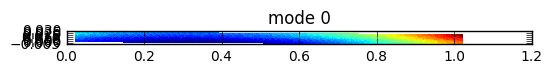

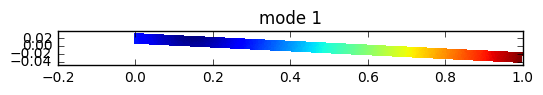

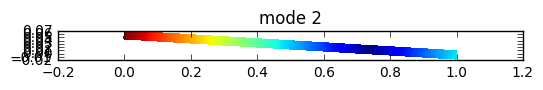

In [45]:
for idx in range(start_mode):
    plt.figure()
    plot(rigid_modes[idx], mode='displacement')
    plt.title("mode {}".format(idx))
    plt.plot()

If we now analyze all eigenvalues we see that there are some values around 0 and most of the values seem to be increasing in a more continuous trend.

[]

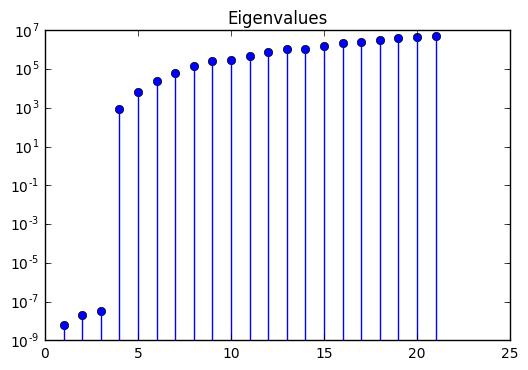

In [46]:
plt.figure()
plt.title('Eigenvalues')
plt.stem(np.arange(1, nmodes+1), abs(np.array(eigvalues)))
plt.yscale('log')
plt.plot()

### Physical properties ###
The eigenvalues correspond to the frequency squared ($\omega^2$), which is related to the period by: $$T_n = \frac{2\pi}{\omega_n}$$


In [47]:
# Look at the first natural frequency and period
freq0 = (np.min(abs(np.array(eigvalues[start_mode])))**0.5).real

# The modal frequencies are related to natural periods by T = 2*pi/f
period0 = 2*np.pi / freq0
print("longest period: ", period0)

# Look at the first natural frequency and period
freq_max = (np.array(eigvalues[-1])**0.5).real

# The modal frequencies are related to natural periods by T = 2*pi/f
period_min = 2*np.pi / freq_max
print("shortest period: ", period_min)

('longest period: ', 0.21467470314405432)
('shortest period: ', 0.0027467270993883006)


Now that we have computed the discretised equations of motion projected on the modal basis, we can start to look at the dynamics. For the dynamic problem we will not concentrate on the modal time-function but use a direct time-integration to show what happens with the modes over time.

### Error analysis ###
In the following lines of code we will show some effects that occur when analyzing the modal matrices a bit more. 

### Modal matrices ###
To test if the modal analysis is executed correctly we can compare the modal mass and stiffness matrices to the eigenvalues since $ k/m = \omega^2 $ so to check that the 

#### Notes ####
Something that is quite surprising to me is that the modal mass matrix is not the identity matrix and the modal stiffness matrix does not contain the eigenvalues on its diagonal. This is surprising to me since the mode shapes (eigenvectors) are normalized. 

I don't know why the situation is like this but in the end it does not pose any problems. It probably has to do with the eigensolver

In [48]:
# For some reason the K_modal matrix does not contain the eigenvalues on the diagonal
# The relative difference between the eigenvalues and the matrix diagonals is still small though
print(np.linalg.norm(K_modal.diagonal() / M_modal.diagonal() - eigvalues) / np.linalg.norm(eigvalues))

4.91781935737e-13


The rigid modes are not well defined (not sure if another eigensolver would work) and the modes are not orthogonal. 

This can be demonstrated if we look at rigid modal matrices which are not diagonal:

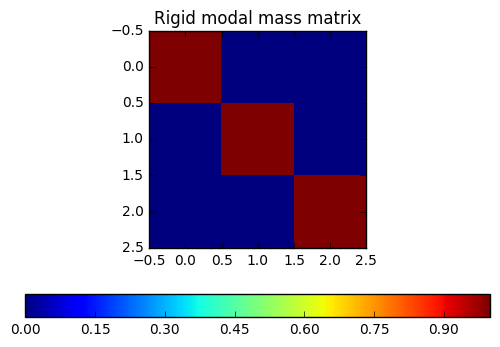

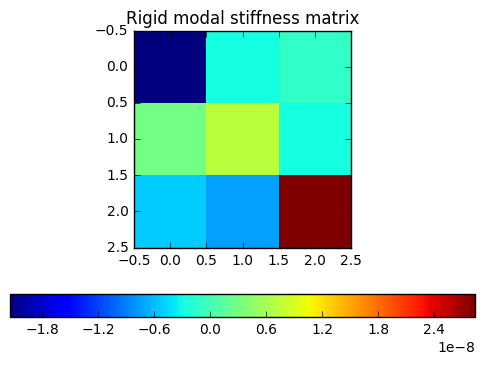

In [49]:
plt.figure()
plt.title("Rigid modal mass matrix")
ax = plt.imshow(M_modal[:start_mode, :start_mode], interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

plt.figure()
plt.title("Rigid modal stiffness matrix")
ax = plt.imshow(K_modal[:start_mode, :start_mode], interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

The vibrational modes are properly orthogonal which means the modal matrices have to be diagonal.

In [50]:
M_modal.diagonal()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

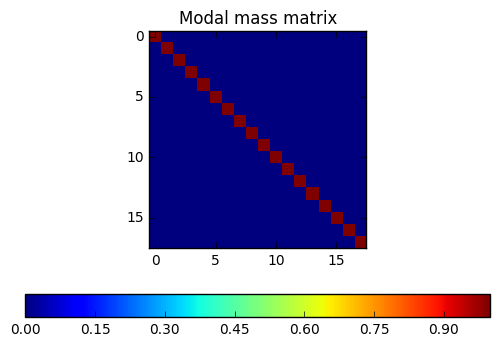

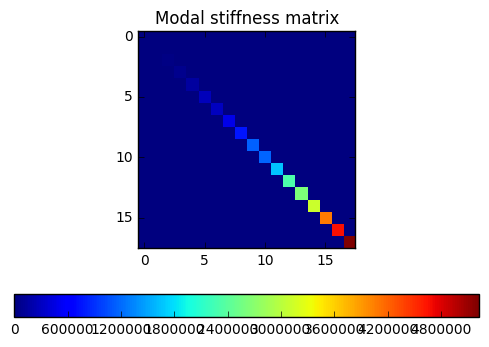

In [51]:
plt.figure()
plt.title("Modal mass matrix")
ax = plt.imshow(M_modal[start_mode:, start_mode:], interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

plt.figure()
plt.title("Modal stiffness matrix")
ax = plt.imshow(K_modal[start_mode:, start_mode:], interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

In [52]:
eigvalues - K_modal.diagonal()

array([  1.50056815e-08,  -2.77344388e-08,   4.70445368e-09,
         2.72810894e-08,   1.41071723e-08,  -4.18476702e-08,
        -5.10335667e-08,  -3.72412615e-07,  -6.51925802e-08,
         4.07453626e-08,  -1.21240737e-06,  -3.14787030e-07,
        -6.49597496e-08,  -1.02794729e-06,  -2.77697109e-06,
        -7.72066414e-07,   1.39698386e-08,  -5.21540642e-08,
        -1.33179128e-07,  -2.85357237e-06,  -1.88313425e-06])

In [53]:
# Look at natural frequencies and natural periods
freqs = (np.array(eigvalues[start_mode:])**0.5).real
# the first two eigenvalues seem to be due to boundary conditions

# The modal frequencies are related to natural periods by T = 2*pi/f
periods = 2*np.pi / freqs
print(periods)

[ 0.2146747   0.07820878  0.04013797  0.02448953  0.01655816  0.01198554
  0.01162789  0.00912615  0.00719674  0.00585394  0.00581446  0.00487123
  0.00413201  0.00387688  0.00355945  0.00310835  0.00290826  0.00274673]


## Types of modes ##

The types of modes encountered physically are either bending or axial compressive modes. 

Note that torsional modes are a rotation around the x-axis which is not included in a 2D-problem.

[]

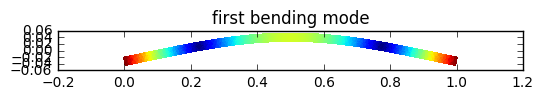

In [54]:
plt.figure()
plt.title("first bending mode")
plot(modes[start_mode], mode='displacement')
plt.plot()

[]

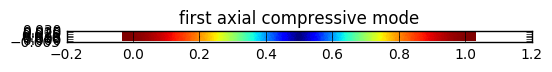

In [55]:
plt.figure()
plt.title("first axial compressive mode")
plot(modes[start_mode+6], mode='displacement')
plt.plot()

Note that both first bending and axial modes are symmetric and have a net zero displacement. The bending mode has one belly and two nodes, whereas the axial mode has one node and two compressive bellies.